Created on 2025, Oct 14.

Description: Implementation of Stacked Periodograms, along with compilation of Lomb-Scargle algorithms.

**@authors:**

 - Cleber Silva < _clebersilva@fisica.ufc.br_ > [1, 3]

 - Eder Martioli < _emartioli@lna.br_ > [2, 3]

[1] Stellar Team - Universidade Federal do Ceará, Brazil.

[2] Laboratório Nacional de Astrofísica, Brasil.

[3] MALTED research group, Brazil.

**References:**

A. Mortier, A. Collier Cameron. A&A 601 A110 (2017) - DOI: https://doi.org/10.1051/0004-6361/201630201

A. Mortier, et al. A&A, 573 (2015) A101 - DOI: https://doi.org/10.1051/0004-6361/201424908

Jacob T. VanderPlas 2018 ApJS 236 16 - DOI: https://doi.org/10.3847/1538-4365/aab766

In [1]:
from astropy.io import ascii
import LS_like_periodograms as aux

In [2]:
file = 'DS1_timeSeries.csv'
table = ascii.read(file)

time = table['Time [eMJD]'].value
RV = table['RV [m/s]'].value
RV_error = table['RV Err. [m/s]'].value

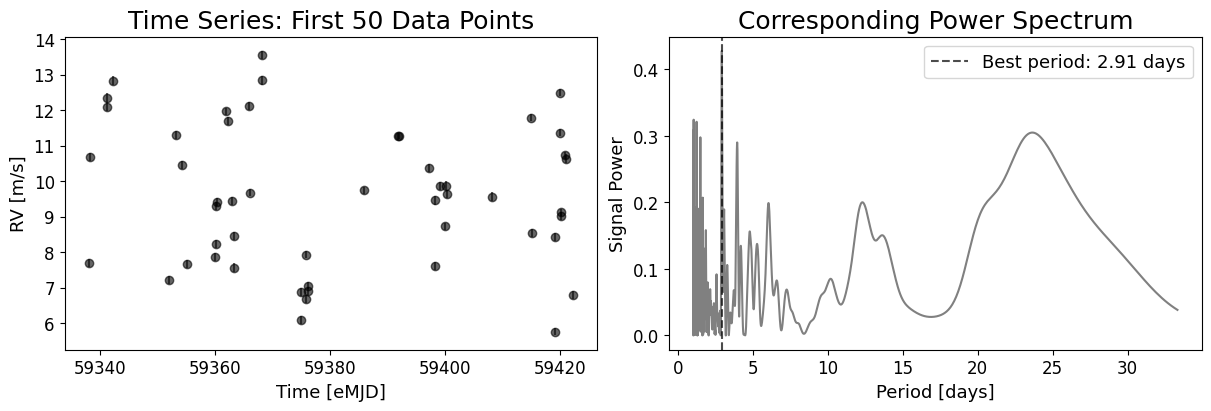

In [3]:
aux.plot_curve_and_periodogram(time, RV, RV_error, 50, periodogram_type='GLS', mode='random')

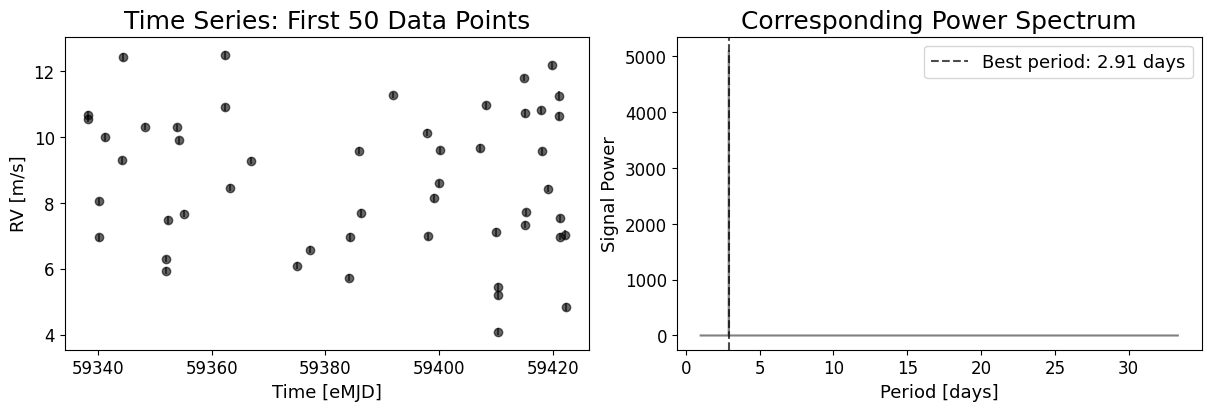

In [4]:
aux.plot_curve_and_periodogram(time, RV, RV_error, 50, periodogram_type='BGLS', mode='random')

In [5]:
data = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                               periodogram_type='GLS', p_min=1,
                               p_max=5, num_periods = 5000,
                               mode='chronological')

100%|██████████| 238/238 [00:00<00:00, 329.99it/s]


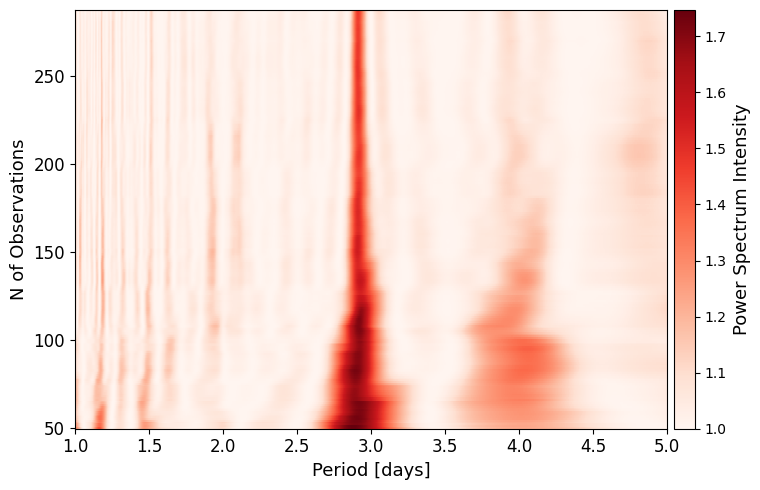

In [6]:
aux.plot_stacked_periodogram_heatmap(data, norm='linear')

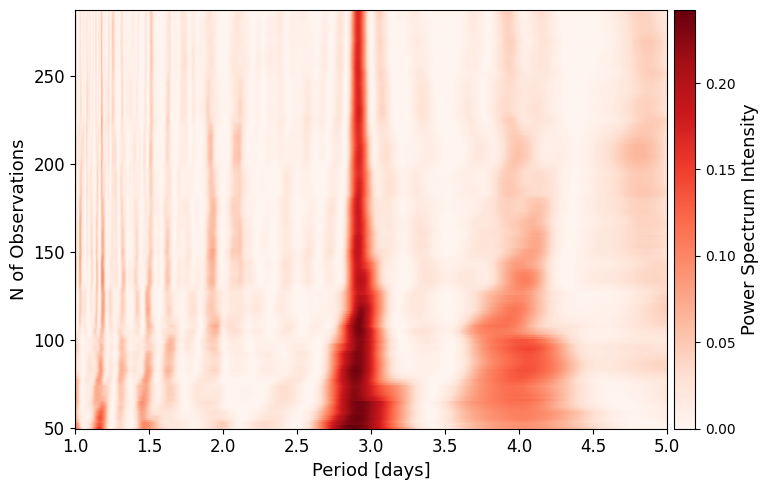

In [7]:
aux.plot_stacked_periodogram_heatmap(data, norm='log')

In [8]:
data2 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                               periodogram_type='GLS', p_min=1,
                               p_max=5, num_periods = 5000,
                               mode='random')

100%|██████████| 238/238 [00:00<00:00, 314.21it/s]


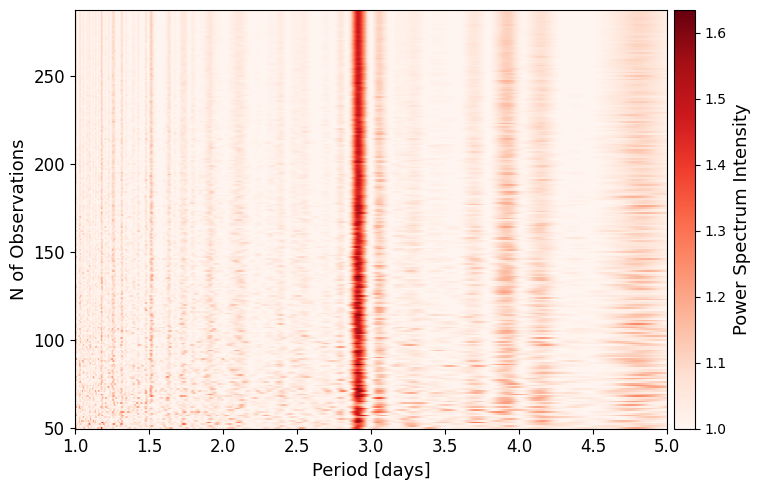

In [9]:
aux.plot_stacked_periodogram_heatmap(data2, norm='linear')

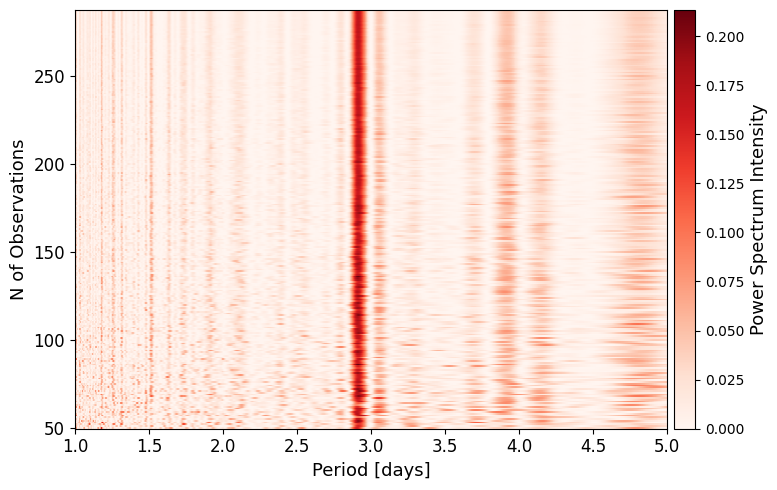

In [10]:
aux.plot_stacked_periodogram_heatmap(data2, norm='log')

In [11]:
data3 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                periodogram_type='BGLS', p_min=1,
                                p_max=5, num_periods = 5000,
                                mode='chronological')

100%|██████████| 238/238 [01:15<00:00,  3.15it/s]


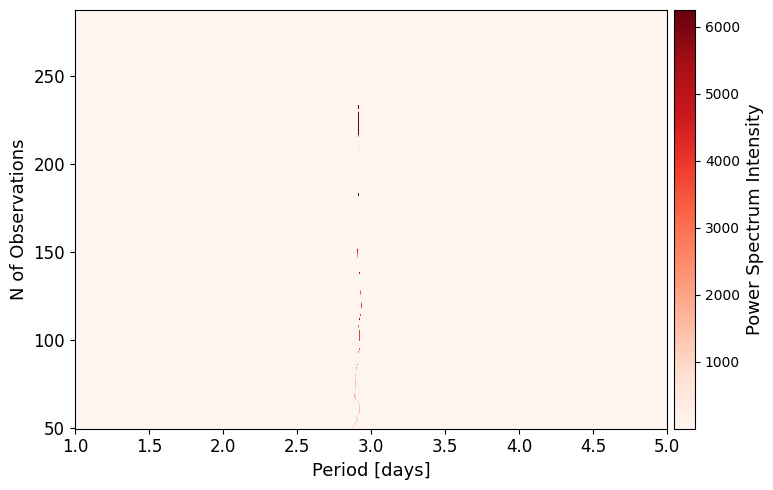

In [12]:
aux.plot_stacked_periodogram_heatmap(data3, norm='linear')

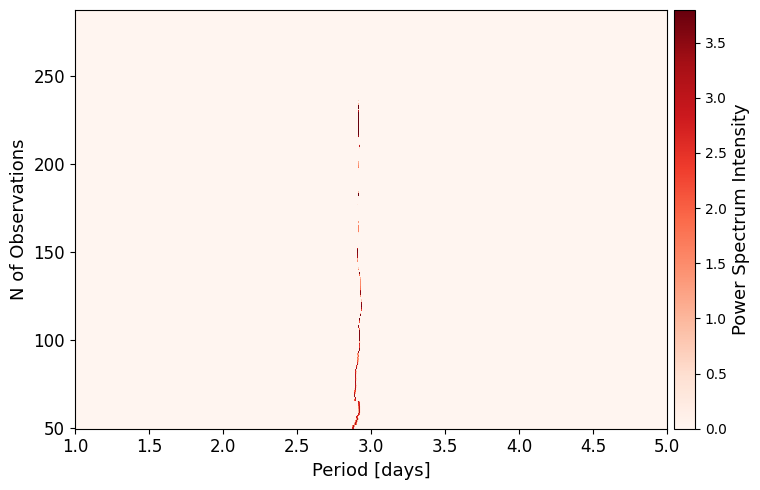

In [13]:
aux.plot_stacked_periodogram_heatmap(data3, norm='log')

In [14]:
data4 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                periodogram_type='BGLS', p_min=1,
                                p_max=5, num_periods = 5000,
                                mode='random')

100%|██████████| 238/238 [01:20<00:00,  2.94it/s]


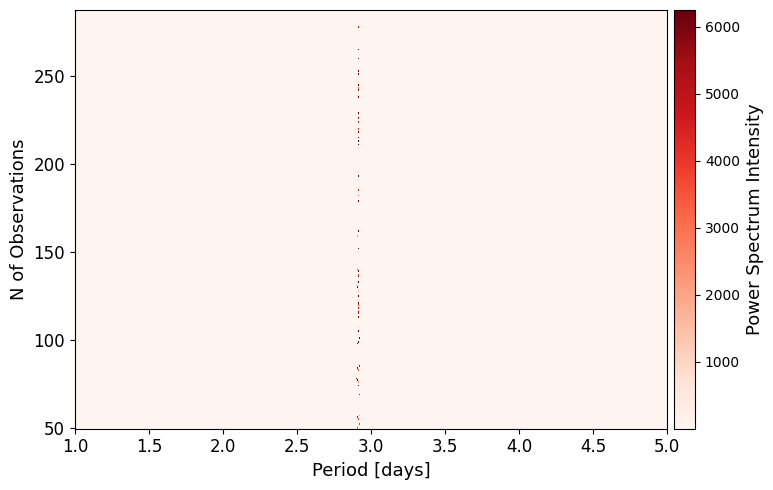

In [15]:
aux.plot_stacked_periodogram_heatmap(data4, norm='linear')

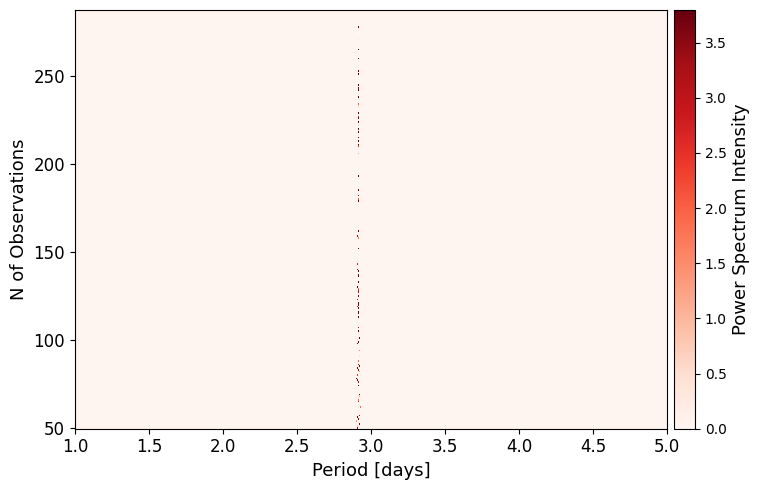

In [16]:
aux.plot_stacked_periodogram_heatmap(data4, norm='log')